[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UM-RMRS/raster_tools/blob/main/notebooks/surface_module.ipynb)

# Raster Tools Surface Module
## This notebook demonstrates the functionality of the Raster Tools surface module 
by John Hogland 4/10/2023

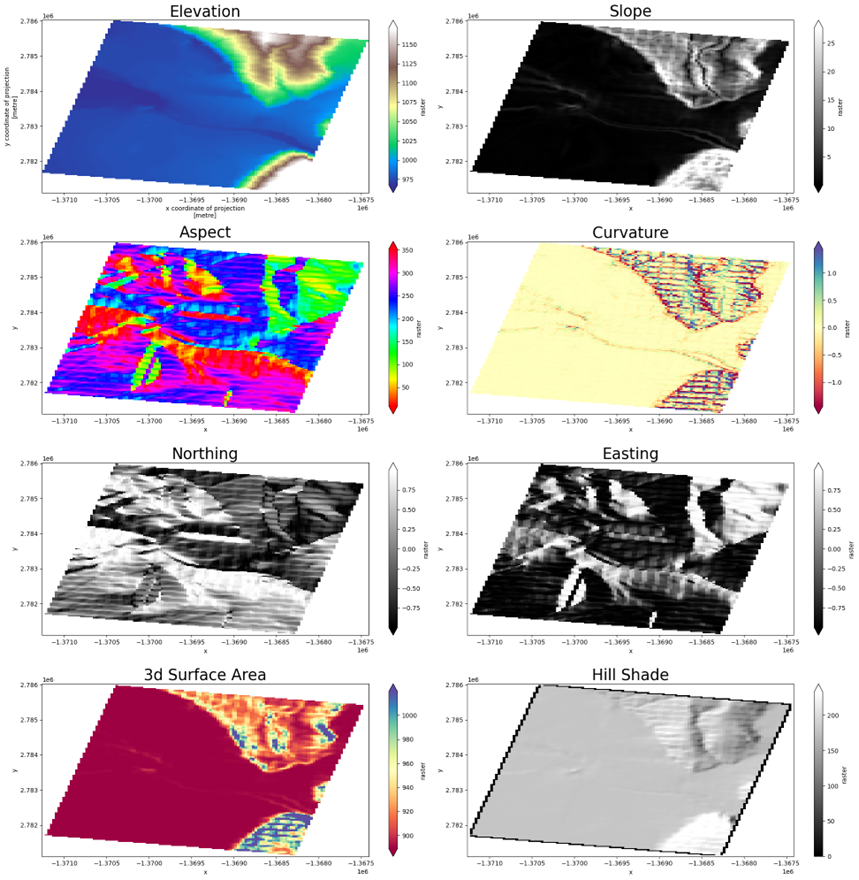

# Install software for Colab

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install --upgrade ipyleaflet
!pip install xarray_leaflet
!pip install raster_tools
!pip install py3dep
!pip install localtileserver

# The Process
In this notebook we download USGS 3dep products that are publicly available and use raster_tools to perform surface processing. At each step in the notebook we will discuss various aspects of the data, processing techniques, and visualization. After completing this notebook you should be very familiar with how to use the surface module.
## Steps
- 1. Create an area of interest (Missoula MT; 46.8721° N, 113.9940° W)
- 2. Use py3dep to download the dem for the area of interest
- 3. transform dem into various surface derivatives (i.e. slope, aspect, curvature, northing, easting, surface area 3d, hill shade)
- 4. Visualize outputs

## Step 1: Create an area of interest (Missoula MT; 46.8721° N, 113.9940° W)
### Import various packages

In [ ]:
import py3dep
import geopandas as gpd
from raster_tools import surface, Raster
from shapely.geometry import shape

### Define area of interest (AOI) using the coordinates of Missoula

In [ ]:
loc = {"type": "Point", "coordinates": [-113.994, 46.8721]}

geom = shape(loc)
geom_buff = gpd.GeoSeries(
    geom.buffer(0.02), crs="EPSG:4326"
)  # buffer out 0.02 degrees to get an area
geom_buff.explore()  # visualize

## Step 2: Get DEM data from USGS wms servers
### Create a get_3dep_data function to download USGS data and return a Raster object

In [ ]:
def get_3dep_data(sgeo, srv="DEM", res=30, out_crs=None):
    """
    downloads 3dep data from a specified service and resolution and returns a raster object

    sgeo: object, polygon | mulipolygon | bounding box [minx, miny, maxx, maxy] used to extract data (WGS 84 - EPSG:4326)
    srv: string, name of the 3dep service
    res: int, spatial resolution
    out_crs: object, optional crs used to project geopandas dataframe to a differnt crs

    return: raster object
    """
    ar = py3dep.get_map(srv, sgeo, resolution=res).expand_dims({"band": 1})
    out_rs = Raster(ar)
    if not out_crs is None:
        out_rs = Raster(out_rs.xdata.rio.reproject(out_crs))

    return out_rs

### Use get_3dep_data to donwload DEM for AOI (resolution 30 m) and save the raster.

In [ ]:
elv = get_3dep_data(
    list(geom_buff.total_bounds), srv="DEM", res=30
)  # data are returned in lat lon (WGS 84) with height in meters
elv = elv.save("elv.tif")

### Visualize elevation raster using ipyleaflet

In [ ]:
from localtileserver import TileClient, get_leaflet_tile_layer
from ipyleaflet import Map, LayersControl, basemaps, basemap_to_tiles

# Specify the name of the predictor raster stack
outname = "elv.tif"

# Create a TileClient from a raster file
client = TileClient(outname)

# Create ipyleaflet TileLayer from that server
t = get_leaflet_tile_layer(client, band=[1], name="BAA (ft squared/acre)")

# Create ipyleaflet map, add tile layer, and display
m = Map(center=client.center(), zoom=client.default_zoom)
wi = basemap_to_tiles(basemaps.Esri.WorldImagery)
wi.name = "ESRI World Imagery"
m.add(wi)
m.add(t)

# add the layer control
control = LayersControl(position="topright")
m.add_control(control)
m

## Step 3: Transform DEM
- Project the elevation data to a projected coordinate system (Albers Equal Area; EPSG:5070)
- create slope
- create aspect
- create curvature
- create northing
- create easting
- create surface area 3d
- hillshade

In [ ]:
elv_p = Raster(elv.xdata.rio.reproject("EPSG:5070"))  # reproject to Albers
slp = surface.slope(
    elv_p, degrees=True
)  # slope: by default degrees to get percent set degrees flag to false
asp = surface.aspect(elv_p)  # aspect
curv = surface.curvature(elv_p)  # curvature
north = surface.northing(
    elv_p
)  # northing assumes elevation raster alterntively one could specify a aspect raster
east = surface.easting(
    elv_p
)  # easting assumes elevation raster alterntively one could specify a aspect raster
s3d = surface.surface_area_3d(
    elv_p
)  # calculates 3d surface area after Jense, 2004
hill = surface.hillshade(
    elv_p
)  # calculates hill shade; can specify azimuth and sun altitude

## Step 4: Visualize the rasters

In [ ]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(figsize=(20, 20), ncols=2, nrows=4, tight_layout=True)

rslst = [elv_p, slp, asp, curv, north, east, s3d, hill]
clms = [
    "Elevation",
    "Slope",
    "Aspect",
    "Curvature",
    "Northing",
    "Easting",
    "3d Surface Area",
    "Hill Shade",
]
cramp = [
    plt.cm.terrain,
    plt.cm.gray,
    plt.cm.hsv,
    plt.cm.Spectral,
    plt.cm.gray,
    plt.cm.gray,
    plt.cm.Spectral,
    plt.cm.gray,
]
for x in range(len(clms)):
    c = x % 2
    r = x // 2
    rslst[x].plot(ax=axes[r, c], robust=True, cmap=cramp[x])
    axes[r, c].set_title(clms[x], fontdict={"fontsize": 25, "fontweight": 3})

# This ends the Raster Tools surface module notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/tree/main/notebooks
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html